In [1]:
import arviz as az
import numpy as np
"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

import random
import pickle
import os
import sys
import matplotlib.pyplot as plt

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path
from pickle import UnpicklingError

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def load_training_data(base_path, step, min_traj_lenth, pair_id_list, N):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    for pair_id in pair_id_list:
        if pair_id == pair_id_list[0]:
            vt = tracks[pair_id]['vFollReal']
            s = tracks[pair_id]['sReal']
            dv = tracks[pair_id]['dvReal']
            label_v = tracks[pair_id]['vFollReal_next']
            id_idx = N*np.ones_like(label_v, dtype=int)
        else:
            vt = np.concatenate((vt,tracks[pair_id]['vFollReal']))
            s = np.concatenate((s,tracks[pair_id]['sReal']))
            dv = np.concatenate((dv, tracks[pair_id]['dvReal']))
            label_v = np.concatenate((label_v, tracks[pair_id]['vFollReal_next']))
            id_idx = np.concatenate((id_idx, N*np.ones_like(tracks[pair_id]['sReal'], dtype=int)))
        N +=1
    vt = vt[0:-1:step]
    s = s[0:-1:step]
    dv = dv[0:-1:step]
    label_v = label_v[0:-1:step]
    id_idx = id_idx[0:-1:step]
    
    print("Traj length:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return vt, s, dv, label_v, id_idx

def Bayesian_IDM_hierarchical(base_path, step):
    vt, s, dv, label_v, id_idx = load_training_data(base_path, step=step, min_traj_lenth=50/Config.dt,
                                                    pair_id_list=Config.car_interactive_pair_list[0:8], N=0)

    vt2, s2, dv2, label_v2, id_idx2 = load_training_data(base_path, step=step, min_traj_lenth=50/Config.dt,
                                                         pair_id_list=Config.truck_interactive_pair_list[0:8],
                                                         N=len(Config.car_interactive_pair_list[0:8]))
    vt = np.concatenate((vt,vt2))
    s = np.concatenate((s, s2))
    dv = np.concatenate((dv, dv2))
    label_v = np.concatenate((label_v,label_v2))
    id_idx = np.concatenate((id_idx,id_idx2))
    
    print("training size:", label_v.shape[0])
    ################################################

    dt = Config.dt

    D = 5
    
    N_veh = len(Config.car_interactive_pair_list[0:8])+len(Config.truck_interactive_pair_list[0:8])
    coords = {
    "veh_id": np.arange(N_veh),
    "obs_id": np.arange(label_v.shape[0]),
    }
    
   
    with pm.Model(coords=coords) as hierarchical_model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * tt.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * Config.dt
        
        id_idx = pm.ConstantData("id_idx", id_idx, dims="obs_id")
        s_ = pm.ConstantData("s", s, dims="obs_id")
        vt_ = pm.ConstantData("vt", vt, dims="obs_id")
        dv_ = pm.ConstantData("dv", dv, dims="obs_id")
        
        # Hyperpriors for group nodes
        chol, _, _ = pm.LKJCholeskyCov('chol', n=D, eta=2.0, sd_dist=pm.Exponential.dist(100.0, shape=D))
        cov = pm.Deterministic('cov', chol.dot(chol.T))
        vals_raw = pm.Normal('vals_raw',mu=0, sigma=1, shape=(N_veh, D), dims=('veh_id', ...))

        DELTA = 4
        
        log_mu_prior = pm.floatX(np.array([2., 0.69, 0.47, -.3, .51]))
        
        log_mu = pm.MvNormal('log_mu', log_mu_prior, chol=chol)
        mu = pm.Deterministic('mu', tt.exp(log_mu))
        
        log_parameters = pm.Deterministic('log_mu_d', log_mu+tt.dot(chol,vals_raw.T).T)
        parameters = pm.Deterministic('mu_d', tt.exp(log_parameters))
        print("parameters.shape.eval():", parameters.shape.eval())
        
        log_s_v = pm.Uniform('log_s_v', lower=-5.0, upper=-1.0)
        s_v = pm.Deterministic('s_v', tt.exp(log_s_v))

        v_obs = pm.Normal('obs', mu=IDM_v(parameters[id_idx,0], parameters[id_idx,1], parameters[id_idx,2],
                                          parameters[id_idx,3], parameters[id_idx,4],  DELTA,
                                          s_, vt_, dv_), sigma=s_v, observed=label_v, dims="obs_id")

        tr = pm.sample(20000, tune=50000, random_seed=37, init='jitter+adapt_diag_grad', chains=1,
                       cores=8, discard_tuned_samples=True, return_inferencedata=True, target_accept=0.8)
        
    return tr, hierarchical_model

In [3]:
base_path = '../data/highD/'
step = 4
tr, model = Bayesian_IDM_hierarchical(base_path, step)

Traj length: 50.0 , ID list: range(35, 43) , Data size: (3185,)
Traj length: 50.0 , ID list: [5, 6, 20, 57, 66, 73, 79, 80] , Data size: (3021,)
training size: 6206
parameters.shape.eval(): [16  5]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Sequential sampling (1 chains in 1 job)
NUTS: [chol, vals_raw, log_mu, log_s_v]


Sampling 1 chain for 50_000 tune and 20_000 draw iterations (50_000 + 20_000 draws total) took 19746 seconds.
There were 416 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [3]:
# Save the trace in the `cache' folder
base_path = '../data/highD/'
cache = "../PGM/cache/Bayesian_IDM_hierarchical-exp2.pkl"
if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    print("Generated and Saved", output_file, ": done!")

Load trace ../PGM/cache/Bayesian_IDM_hierarchical-exp2.pkl : done!


In [4]:
az.summary(tr, var_names=["mu", "log_mu"],coords={"chain":[0]}) # index 0-5 are: VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA
# six IDM parameters for the population driver

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],27.184,3.973,20.667,34.650,0.054,0.039,6268.0,5945.0,NaN
mu[1],3.640,0.254,3.163,4.119,0.004,0.003,4446.0,7108.0,NaN
mu[2],0.811,0.086,0.658,0.976,0.002,0.001,2374.0,3528.0,NaN
mu[3],0.424,0.039,0.354,0.501,0.000,0.000,6419.0,8737.0,NaN
mu[4],2.066,0.211,1.681,2.464,0.002,0.001,10816.0,11014.0,NaN
log_mu[0],3.293,0.139,3.049,3.563,0.002,0.001,6268.0,5945.0,NaN
log_mu[1],1.290,0.070,1.157,1.421,0.001,0.001,4446.0,7108.0,NaN
log_mu[2],-0.215,0.106,-0.416,-0.023,0.002,0.002,2374.0,3528.0,NaN
log_mu[3],-0.862,0.092,-1.033,-0.688,0.001,0.001,6419.0,8737.0,NaN
log_mu[4],0.721,0.101,0.532,0.912,0.001,0.001,10816.0,11014.0,NaN


In [11]:
az.summary(tr, var_names=["mu_d", "log_mu"],coords={"chain":[0], "mu_d_dim_0": [3,8]}) # index 0-4 are: VMAX, DSAFE, TSAFE, AMAX, AMIN
# IDM parameters for the population driver

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mu_d[3, 0]",29.340,7.475,18.591,42.832,0.061,0.044,18655.0,14430.0,NaN
"mu_d[3, 1]",3.173,0.071,3.037,3.304,0.000,0.000,21142.0,18719.0,NaN
"mu_d[3, 2]",0.709,0.023,0.667,0.751,0.000,0.000,21402.0,18209.0,NaN
"mu_d[3, 3]",0.917,0.050,0.823,1.009,0.000,0.000,21055.0,18006.0,NaN
"mu_d[3, 4]",1.319,0.181,0.989,1.653,0.001,0.001,21639.0,15966.0,NaN
"mu_d[8, 0]",31.013,8.386,18.745,46.374,0.063,0.046,20600.0,15135.0,NaN
"mu_d[8, 1]",2.800,0.550,1.797,3.803,0.005,0.003,15670.0,13050.0,NaN
"mu_d[8, 2]",1.680,0.167,1.361,1.976,0.001,0.001,16168.0,13672.0,NaN
"mu_d[8, 3]",0.287,0.048,0.199,0.376,0.000,0.000,19044.0,16103.0,NaN
"mu_d[8, 4]",1.246,0.193,0.902,1.616,0.001,0.001,18249.0,15049.0,NaN


In [7]:
tr.posterior.s_v.mean(axis=0).mean(axis=0)/Config.dt

<xarray.DataArray 's_v' ()>
array(0.33395425)

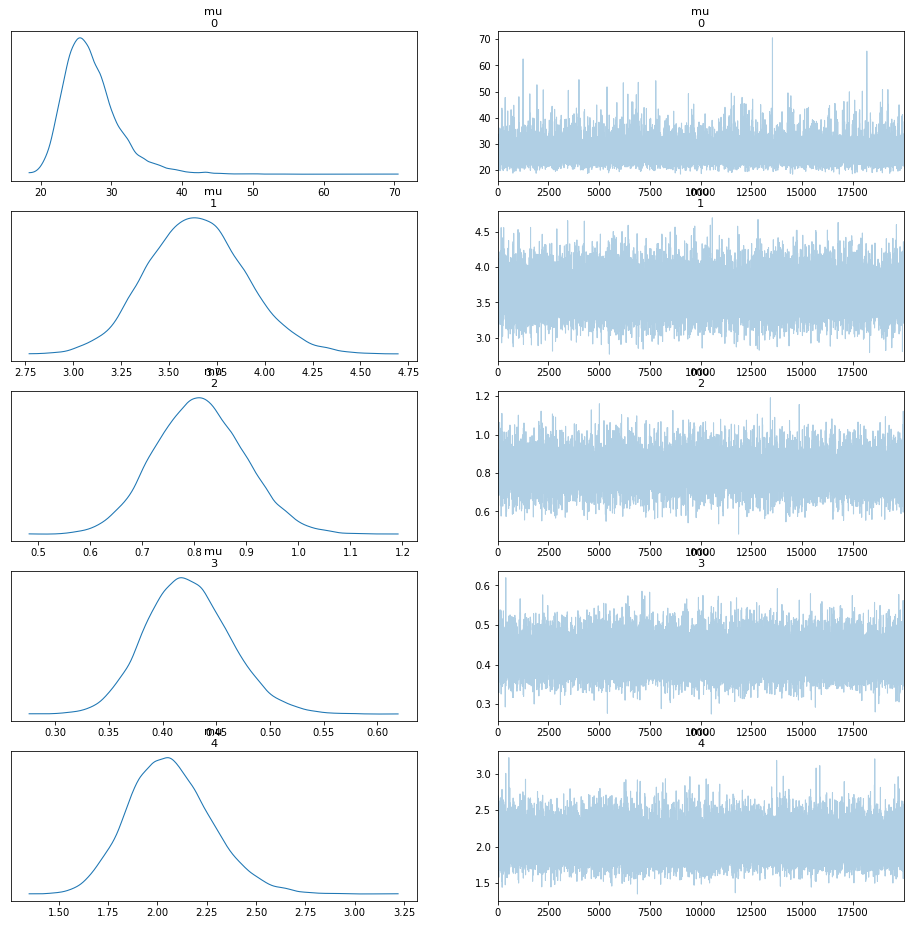

In [8]:
import arviz as az

_ = az.plot_trace(tr, var_names=["mu"], figsize=((16, 16)),compact=False)

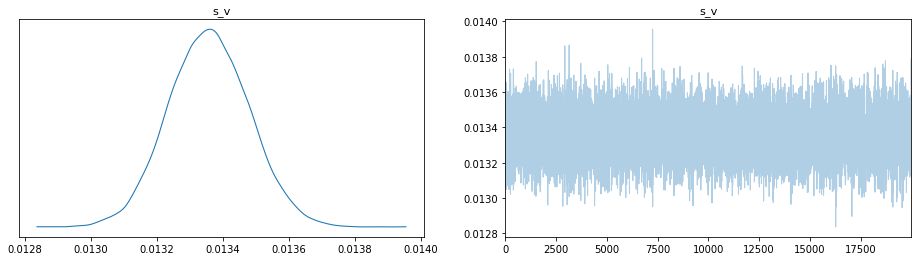

In [9]:
import arviz as az

_ = az.plot_trace(tr, var_names=["s_v"], figsize=((16, 4)))

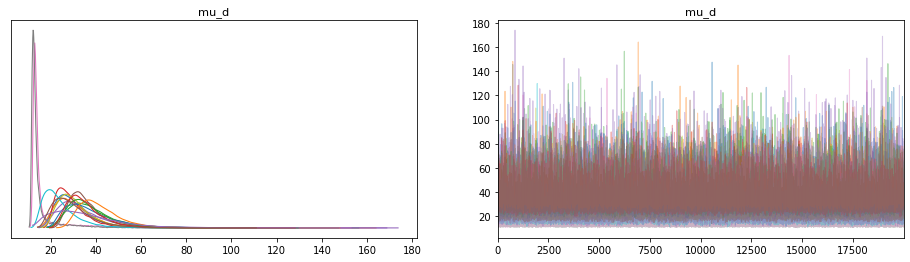

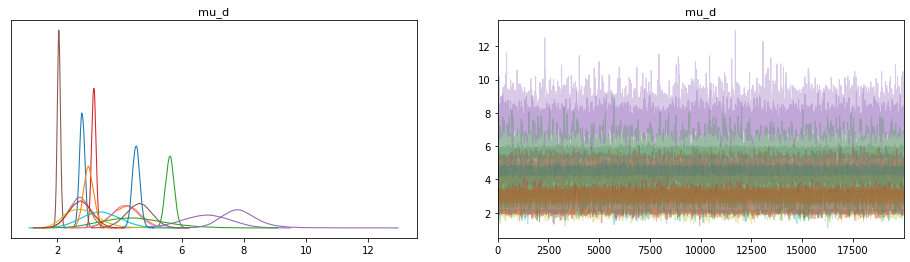

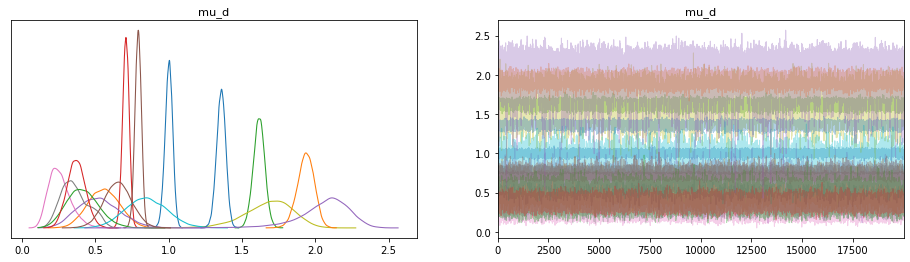

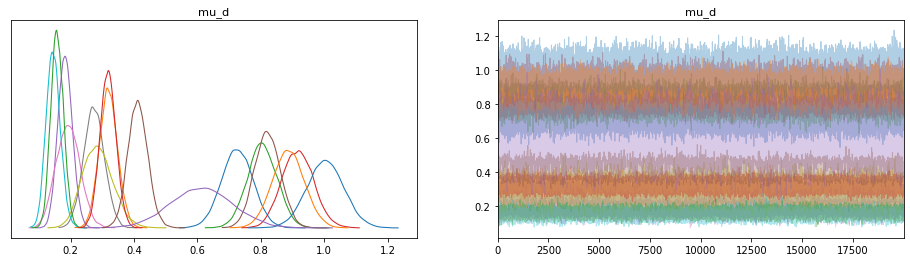

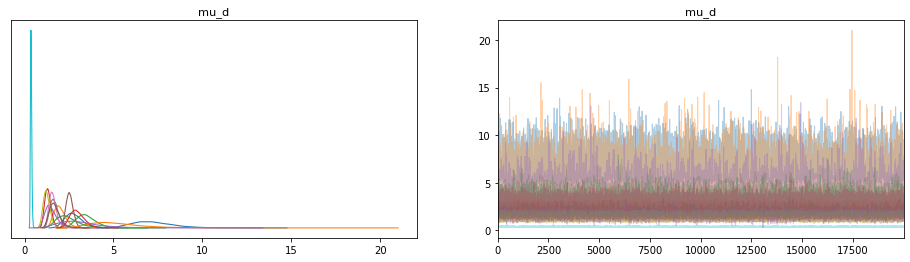

In [10]:
import arviz as az

_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":0}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":1}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":2}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":3}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":4}, figsize=((16, 4)),compact=True)

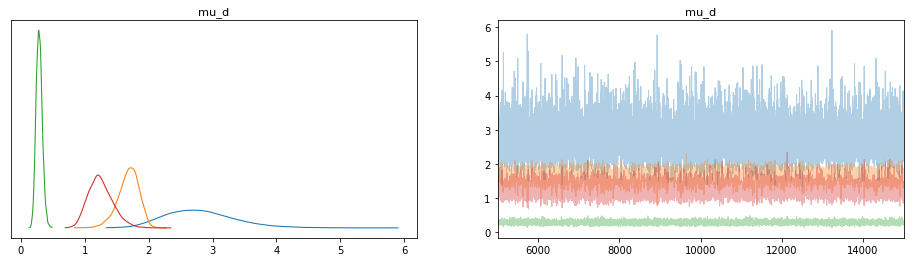

In [8]:
import arviz as az

driver_id = 8

_ = az.plot_trace(tr, var_names=["mu_d"],
                  coords={"mu_d_dim_0":driver_id, "mu_d_dim_1":[1,2,3,4], 'draw':range(5000,15000)},
                  figsize=((16, 4)),compact=True)

# _ = az.plot_trace(tr, var_names=["mu_d"],
#                   coords={"mu_d_dim_0":driver_id, "mu_d_dim_1":0, 'draw':range(7500,15000)},
#                   figsize=((16, 4)),compact=True)

In [9]:
driver_id = 8

az.summary(tr, var_names=["mu_d","log_mu_d"], coords={"mu_d_dim_0":driver_id, "log_mu_d_dim_0":driver_id, "chain":[0]}) # index 0-5 are: VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA
# AMIN for vehicle 55-64

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_d[0],31.013,8.386,18.745,46.374,0.063,0.046,20600.0,15135.0,NaN
mu_d[1],2.800,0.550,1.797,3.803,0.005,0.003,15670.0,13050.0,NaN
mu_d[2],1.680,0.167,1.361,1.976,0.001,0.001,16168.0,13672.0,NaN
mu_d[3],0.287,0.048,0.199,0.376,0.000,0.000,19044.0,16103.0,NaN
mu_d[4],1.246,0.193,0.902,1.616,0.001,0.001,18249.0,15049.0,NaN
log_mu_d[0],3.403,0.246,2.956,3.853,0.002,0.001,20600.0,15135.0,NaN
log_mu_d[1],1.010,0.195,0.636,1.368,0.002,0.001,15670.0,13050.0,NaN
log_mu_d[2],0.513,0.104,0.318,0.689,0.001,0.001,16168.0,13672.0,NaN
log_mu_d[3],-1.264,0.169,-1.584,-0.956,0.001,0.001,19044.0,16103.0,NaN
log_mu_d[4],0.208,0.154,-0.082,0.495,0.001,0.001,18249.0,15049.0,NaN


In [15]:
az.summary(tr, var_names=["mu_d"], coords={"mu_d_dim_0":[0,12], "chain":[0]})
# index 0-4 are: VMAX, DSAFE, TSAFE, AMAX, AMIN
# IDM parameters for vehicle 55 AND 59

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mu_d[0, 0]",26.099,6.210,16.442,37.390,0.048,0.036,20540.0,14455.0,NaN
"mu_d[0, 1]",2.821,0.098,2.640,3.008,0.001,0.000,30269.0,15841.0,NaN
"mu_d[0, 2]",0.990,0.032,0.930,1.051,0.000,0.000,27577.0,17527.0,NaN
"mu_d[0, 3]",0.665,0.009,0.649,0.682,0.000,0.000,35921.0,14737.0,NaN
"mu_d[0, 4]",2.363,0.394,1.661,3.105,0.002,0.002,33562.0,15819.0,NaN
"mu_d[12, 0]",32.979,6.426,22.746,44.743,0.047,0.037,25238.0,12115.0,NaN
"mu_d[12, 1]",11.405,0.476,10.506,12.267,0.004,0.003,15996.0,16997.0,NaN
"mu_d[12, 2]",0.098,0.051,0.019,0.191,0.000,0.000,11589.0,11279.0,NaN
"mu_d[12, 3]",0.647,0.008,0.632,0.663,0.000,0.000,35813.0,15675.0,NaN
"mu_d[12, 4]",1.564,0.460,0.793,2.385,0.003,0.002,31960.0,14206.0,NaN


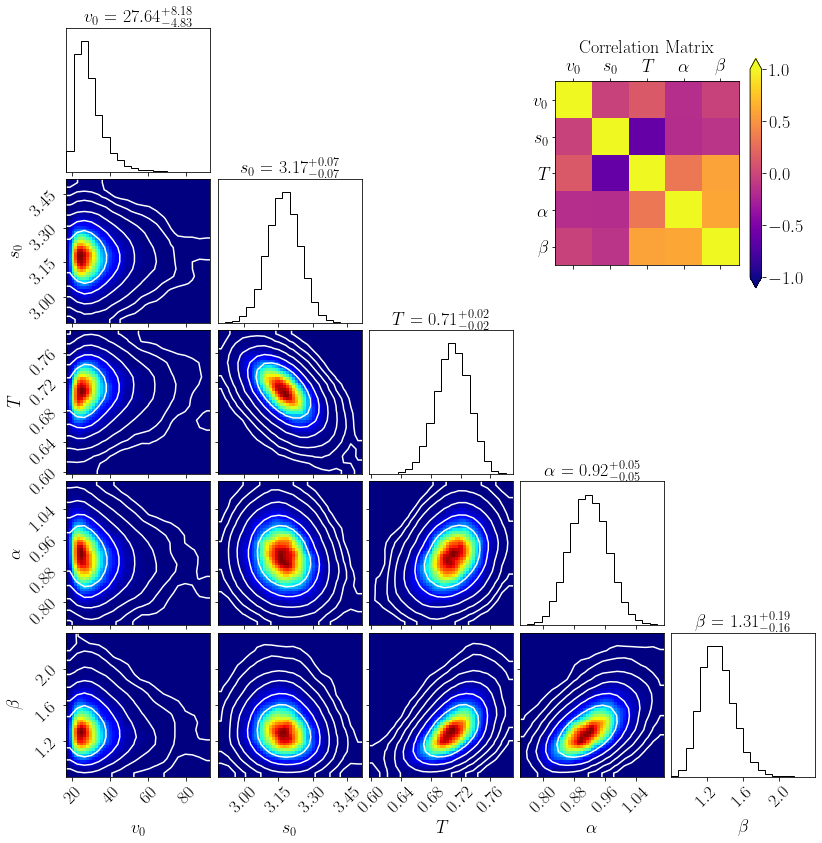

In [5]:
import corner

driver_id = 3

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id,"chain":[0]},
    smooth=1.,
    color = 'k',
    plot_contours=True,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure_d.savefig('../Figs/B_IDM_hierarchical_driver2.pdf', dpi=300)

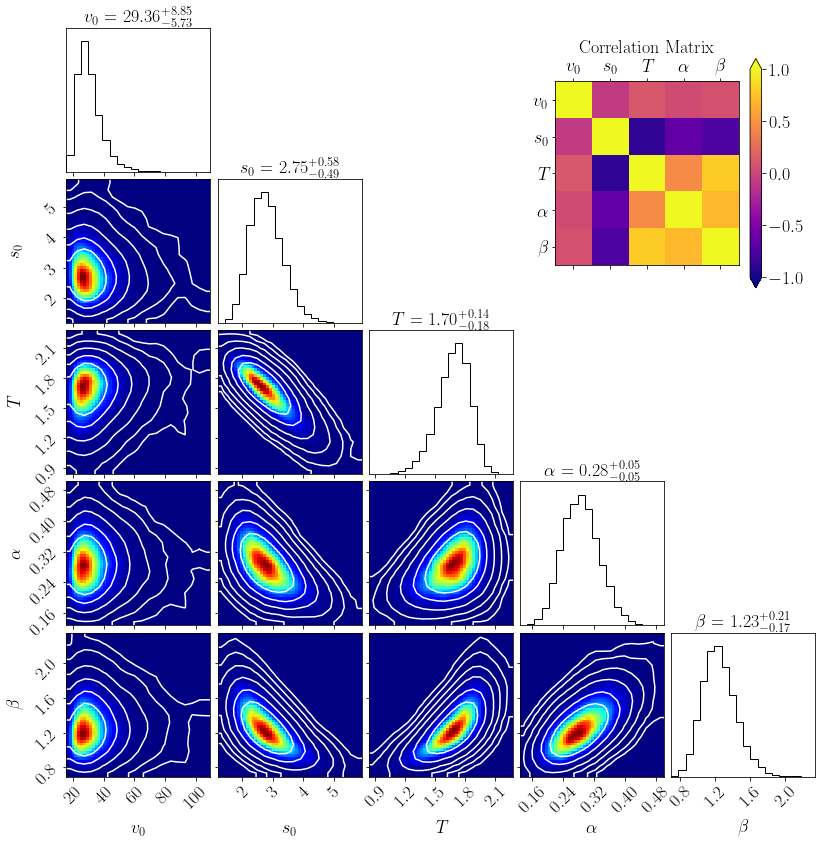

In [6]:
import corner

driver_id = 8

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id,"chain":[0]},
    smooth=1.,
    color = 'k',
    plot_contours=True,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

figure_d.savefig('../Figs/B_IDM_hierarchical_driver8.pdf', dpi=300)

In [12]:
az.waic(tr, model)

Computed from 40000 posterior samples and 6206 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 17953.72    62.96
p_waic       50.14        -